<a href="https://colab.research.google.com/github/Melumi11/MHacks_2023/blob/main/frauddetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

url = 'https://raw.githubusercontent.com/Melumi11/MHacks_2023/main/MHacks_data.csv?token=GHSAT0AAAAAAB7OQM6WVYYNRJEBKVYSMECWZK2DRXQ'
df = pd.read_csv(url)

In [ ]:
import numpy as np
from imblearn.over_sampling import SMOTE
from sklearn.cluster import KMeans

## Visualization
# set seaborn style because it prettier
sns.set()

## Metrics
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import roc_curve, auc

## Models
import xgboost as xgb
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import average_precision_score
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier, plot_importance
import pickle

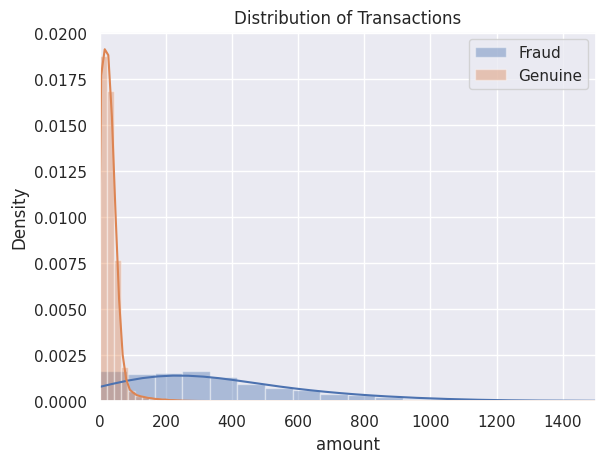

In [ ]:
fig, axs = plt.subplots()

sns.distplot(df[df['fraud'] == 1]['amount'], bins=100, label="Fraud")
axs.set_title("Distribution of Transactions")

sns.distplot(df[df['fraud'] == 0]['amount'], bins=100, label="Genuine")
axs.set_xlim(0, 1500)
axs.legend()
plt.show()

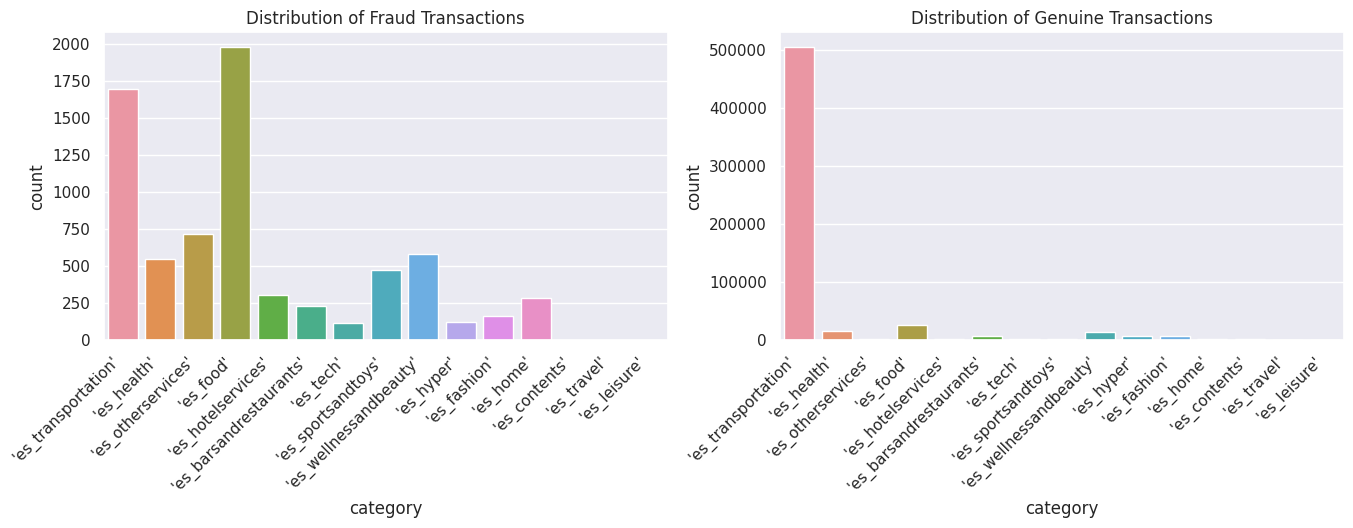

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)

sns.countplot(x='category', data=df[df['fraud'] == 1], ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.countplot(x='category', data=df[df['fraud'] == 0], ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")

# Rotate x-axis labels for better visibility
for ax in axs:
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, ha='right')

plt.show()


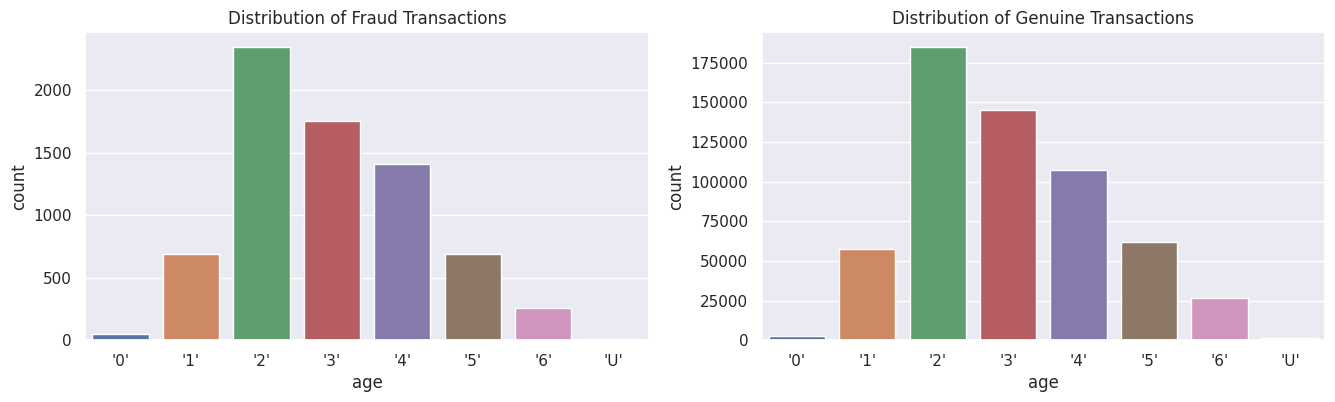

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)
age_order = df['age'].unique()  # Get unique age categories
age_order.sort()  # Sort the categories

sns.countplot(x='age', data=df[df['fraud'] == 1], ax=axs[0], order=age_order)
axs[0].set_title("Distribution of Fraud Transactions")

sns.countplot(x='age', data=df[df['fraud'] == 0], ax=axs[1], order=age_order)
axs[1].set_title("Distribution of Genuine Transactions")


plt.show()


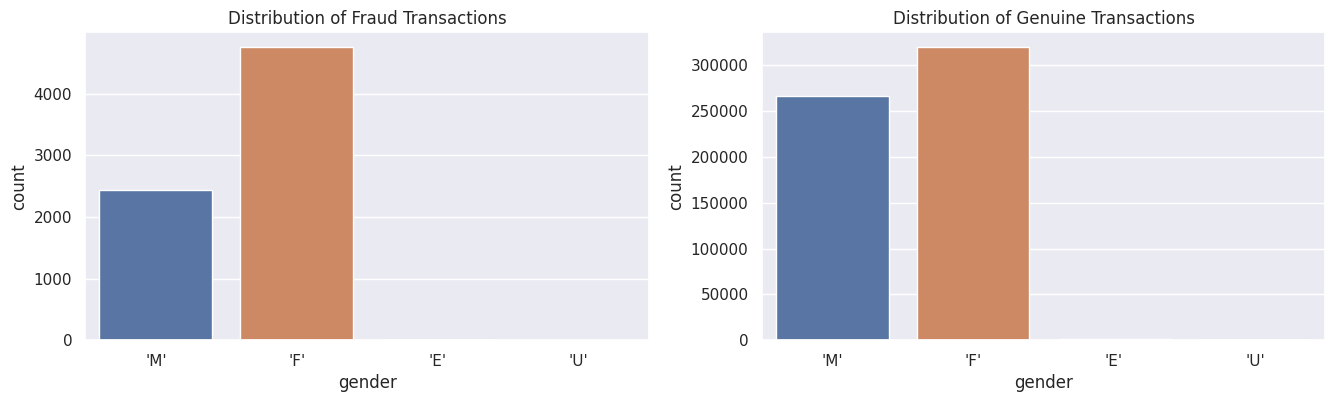

In [ ]:
fig, axs = plt.subplots(ncols=2, figsize=(16, 4), sharex=True)

sns.countplot(x='gender', data=df[df['fraud'] == 1], ax=axs[0])
axs[0].set_title("Distribution of Fraud Transactions")

sns.countplot(x='gender', data=df[df['fraud'] == 0], ax=axs[1])
axs[1].set_title("Distribution of Genuine Transactions")


plt.show()

In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
data_reduced = df.drop(['zipcodeOri','zipMerchant'],axis=1)
col_categorical = data_reduced.select_dtypes(include= ['object']).columns
for col in col_categorical:
    data_reduced[col] = data_reduced[col].astype('category')
# categorical values ==> numeric values
data_reduced[col_categorical] = data_reduced[col_categorical].apply(lambda x: x.cat.codes)
X = data_reduced.drop(['fraud'],axis=1)
y = df['fraud']
y[y==1].count()
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_resample(X, y)
y_res = pd.DataFrame(y_res)
X_train, X_test, y_train, y_test = train_test_split(X_res,y_res,test_size=0.3,random_state=42,shuffle=True,stratify=y_res)

In [ ]:
def plot_roc_auc(y_test, preds):
    '''
    Takes actual and predicted(probabilities) as input and plots the Receiver
    Operating Characteristic (ROC) curve
    '''
    fpr, tpr, threshold = roc_curve(y_test, preds)
    roc_auc = auc(fpr, tpr)
    plt.title('Receiver Operating Characteristic')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate')
    plt.xlabel('False Positive Rate')
    plt.show()

Classification Report for K-Nearest Neighbours: 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99    176233
           1       0.98      1.00      0.99    176233

    accuracy                           0.99    352466
   macro avg       0.99      0.99      0.99    352466
weighted avg       0.99      0.99      0.99    352466

Confusion Matrix of K-Nearest Neigbours: 
 [[171999   4234]
 [   362 175871]]


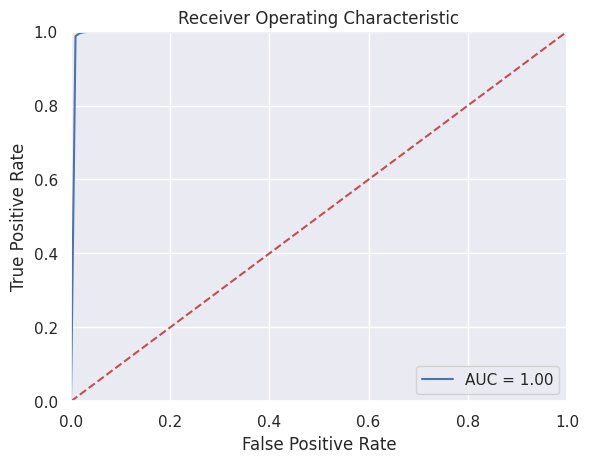

Accuracy: 98.70%


In [ ]:
knn = KNeighborsClassifier(n_neighbors=5,p=1)

knn.fit(X_train,y_train)
y_pred = knn.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print("Classification Report for K-Nearest Neighbours: \n", classification_report(y_test, y_pred))
print("Confusion Matrix of K-Nearest Neigbours: \n", confusion_matrix(y_test,y_pred))
plot_roc_auc(y_test, knn.predict_proba(X_test)[:,1])
print(f"Accuracy: {accuracy:.2%}")

In [ ]:
def get_model_results(X_train: np.ndarray, y_train: np.ndarray,
                      X_test: np.ndarray, y_test: np.ndarray, model):
    """
    model: sklearn model (e.g. RandomForestClassifier)
    """
    # Fit your training model to your training set
    model.fit(X_train, y_train)

    # Obtain the predicted values and probabilities from the model
    predicted = model.predict(X_test)

    try:
        probs = model.predict_proba(X_test)
        print('ROC Score:')
    except AttributeError:
        pass

    # Print the ROC curve, classification report and confusion matrix
    print('\nClassification Report:')
    print(classification_report(y_test, predicted))
    print('\nConfusion Matrix:')
    print(confusion_matrix(y_test, predicted))

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
clf1 = LogisticRegression(class_weight={0:1, 1:15},
                          random_state=5,
                          solver='liblinear')

clf2 = RandomForestClassifier(class_weight={0:1, 1:12},
                              criterion='gini',
                              max_depth=8,
                              max_features='log2',
                              min_samples_leaf=10,
                              n_estimators=30,
                              n_jobs=-1,
                              random_state=5)

clf3 = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")


# Combine the classifiers in the ensemble model
ensemble_model = VotingClassifier(estimators=[('lr', clf1), ('rf', clf2), ('dt', clf3)], voting='hard')

# Get the results
get_model_results(X_train, y_train, X_test, y_test, ensemble_model)



Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.93      0.97    176233
           1       0.94      1.00      0.97    176233

    accuracy                           0.97    352466
   macro avg       0.97      0.97      0.97    352466
weighted avg       0.97      0.97      0.97    352466


Confusion Matrix:
[[164667  11566]
 [   171 176062]]


In [ ]:
model = RandomForestClassifier(bootstrap=True,
                               class_weight={0:1, 1:12},
                               criterion='entropy',
                               # Change depth of model
                               max_depth=10,
                               # Change the number of samples in leaf nodes
                               min_samples_leaf=10,
                               # Change the number of trees to use
                               n_estimators=20,
                               n_jobs=-1,
                               random_state=5)

# Run the function get_model_results
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97    176233
           1       0.94      1.00      0.97    176233

    accuracy                           0.97    352466
   macro avg       0.97      0.97      0.97    352466
weighted avg       0.97      0.97      0.97    352466


Confusion Matrix:
[[165963  10270]
 [   200 176033]]


In [ ]:
from sklearn.model_selection import train_test_split
X = data_reduced.drop(['fraud'],axis=1)
y = df['fraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create and train the logistic regression model
model = LogisticRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Generate the classification report
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:

Classification Report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00    117512
           1       0.85      0.54      0.66      1417

    accuracy                           0.99    118929
   macro avg       0.92      0.77      0.83    118929
weighted avg       0.99      0.99      0.99    118929


Confusion Matrix:
[[117381    131]
 [   654    763]]


In [ ]:
model = DecisionTreeClassifier(random_state=5,
                              class_weight="balanced")
get_model_results(X_train, y_train, X_test, y_test, model)

ROC Score:

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    117512
           1       0.78      0.74      0.76      1417

    accuracy                           0.99    118929
   macro avg       0.89      0.87      0.88    118929
weighted avg       0.99      0.99      0.99    118929


Confusion Matrix:
[[117207    305]
 [   363   1054]]
